In [1]:
import pandas as pd
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme("paper", "white")

In [2]:
df_users = pd.read_csv("./DSock/Active_Users.csv", index_col=0)
print(df_users.shape)
display(df_users.head())

(116, 55)


,MTurk_ID,username,id,isMod,isObserver,isPuppet,n_reports,puppet,report,issued_posts,...,Q17,Q18,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Strategy
1,A10IUXCZBNYUXC,Jacob_1907,2658,f,f,f,17,0,1,25,...,2.0,2.0,2.0,1.0,1.0,2.0,1.0,4.0,2.0,NaN
2,A15F2JTVAJXITI,Luke_3376,2297,f,t,f,0,0,0,0,...,1.0,3.0,1.0,3.0,1.0,3.0,1.0,4.0,1.0,NaN
3,A173A97OFDAX9F,Claire_679,2601,f,f,f,0,0,0,4,...,1.0,2.0,2.0,1.0,1.0,2.0,1.0,3.0,3.0,NaN
4,A18XVBWB2A270I,Katherine_2323,2338,f,t,f,0,0,0,0,...,1.0,2.0,4.0,2.0,2.0,2.0,1.0,1.0,3.0,NaN
5,A1AIMKA54UBYIQ,Asia_4906,2638,f,f,f,1,0,1,9,...,3.0,3.0,2.0,1.0,2.0,2.0,2.0,4.0,3.0,NaN


In [228]:
df_evals = pd.read_csv("./DSock/human_eval_analysis/attitude_tracking.csv")

df_evals = pd.merge(df_users, df_evals, how="left", left_on="MTurk_ID", right_on="id").rename({"id_x": "id"}, axis=1)

df_evals.index = [f"u{u}" for u in df_evals["id"]]

In [392]:
topics = list("abcdefgh")
deltas = ["10", "21", "32", "43", "54"]

In [358]:
timeline = pd.date_range("2020-09-04-03:59:59", periods=5, tz="utc")

get_change = lambda u, t: df_evals.loc[u][[f"{t}_delta_{d}" for d in deltas]].tolist()

In [396]:
u_change = {
    u: {t: (np.array(get_change(u, t)) != 0).sum() for t in topics}
    for u in df_evals.index
}

In [400]:
pd.DataFrame(u_change)

,u2658,u2297,u2601,u2338,u2638,u2701,u2340,u2719,u2667,u2342,...,u2636,u2734,u2657,u2441,u2714,u2313,u2337,u2350,u2703,u2749
a,1,0,0,0,0,0,5,3,0,0,...,0,1,5,5,2,1,1,0,0,5
b,1,0,0,0,1,0,5,3,0,0,...,0,1,5,5,0,0,1,0,3,5
c,1,0,0,0,0,0,5,1,0,0,...,0,1,5,5,0,1,2,1,0,5
d,1,2,0,0,2,0,5,3,0,0,...,0,1,5,5,2,1,1,0,1,5
e,0,2,0,1,0,0,5,3,0,0,...,0,2,5,5,0,0,1,0,0,5
f,0,0,0,0,0,0,5,1,0,0,...,0,1,5,5,0,0,1,0,0,5
g,1,0,1,2,0,0,5,2,0,1,...,0,1,5,5,1,0,1,0,1,5
h,0,0,0,0,0,0,5,1,0,0,...,0,1,5,5,0,0,1,0,0,5


## get events

+ post events -> nodes
+ comment events -> nodes
+ view events -> edges
+ like events -> edges
+ report events

In [15]:
df_posts = pd.read_csv("./DSock/direct_influence/posts_with_senti_and_topic.csv", parse_dates=["createdAt"])
df_comts = pd.read_csv("./DSock/direct_influence/comments_with_senti_and_topic.csv", delimiter=",", parse_dates=["createdAt"]).dropna(subset=["CommenterId", "PostId"])
df_views = pd.read_csv("./DSock/postViews.csv", delimiter="|", parse_dates=["createdAt"]).dropna(subset=["UserId", "PostId"])
df_likes = pd.read_csv("./DSock/Likes.csv", delimiter="|", parse_dates=["createdAt"]).dropna(subset=["UserId", "PostId"])
df_repts = pd.read_csv("./DSock/ReportUsers.csv", delimiter="|", parse_dates=["createdAt"])

print(f"posts: {df_posts.shape}, comments: {df_comts.shape}, views: {df_views.shape}, likes: {df_likes.shape}, reports: {df_repts.shape}")

posts: (1057, 11), comments: (1615, 11), views: (234178, 10), likes: (1034, 6), reports: (46, 6)


In [17]:
df_likes["UserId"] = df_likes["UserId"].astype(int)
df_likes["PostId"] = df_likes["PostId"].astype(int)

df_comts["CommenterId"] = df_comts["CommenterId"].astype(int)
df_comts["PostId"] = df_comts["PostId"].astype(int)

### create auxiliary graph

In [46]:
G = nx.DiGraph()
for u, uname, obs, sock in df_users[["id", "username", "isObserver", "isPuppet"]].values:
    G.add_node(f"u{u}", id=u, kind="user", name=uname, observer=(obs == "t"), sock=(sock == "t"))

for p, author, senti, score, topic in df_posts[["PostID", "AuthorId", "labels", "scores", "topic_label"]].values:
    G.add_node(f"p{p}", id=p, kind="post", author=author, senti=senti, score=score, topic=topic)

for c, author, senti, score, topic in df_comts[["id", "CommenterId", "labels", "scores", "topic_label"]].values:
    G.add_node(f"c{c}", id=c, kind="comt", author=author, senti=senti, score=score, topic=topic)

# G.add_nodes_from([f"u{u}" for u in df_users["id"]])
# G.add_nodes_from([f"p{p}" for p in df_posts["PostID"]])
# G.add_nodes_from([f"c{c}" for c in df_comts["id"]])

In [47]:
for u, p, t, i in df_views[["UserId", "PostId", "createdAt", "id"]].values:
    p_name = f"p{p}" if p in df_posts["PostID"] else f"c{p}"
    if f"u{u}" in G.nodes and p_name in G.nodes:
        G.add_edge(f"u{u}", p_name, time=t, id=i, kind="view")

for u, p, t, i in df_likes[["UserId", "PostId", "createdAt", "id"]].values:
    if f"u{u}" in G.nodes and f"p{p}" in G.nodes:
        G.add_edge(f"u{u}", f"p{p}", time=t, id=i, kind="like")

In [130]:
def get_subgraph_with_node(G, node_name, topic="a"):
    # children = nx.descendants(G, source=node_name) | {node_name}
    tree = {
        e[1]: {
            "node": G.nodes[e[1]],
            "edge": G.edges[e],
            "time": G.edges[e]["time"],
        }
        # filter with topic
        for e in G.out_edges(node_name) if G.nodes[e[1]]["topic"] == topic
    }

    path = sorted(tree, key=lambda x: tree[x]["time"])
    
    return tree, path

In [426]:
node_name = "u2337"
topic = "a"

tree, path = get_subgraph_with_node(G, node_name, topic)

print(len(path))

12


#### define colors and styles for graph drawing

In [427]:
use_color = sns.color_palette("Set2")

line_map = {
    "view": "-",
    "like": ".",
}

color_map = {
    "view": 0,
    "like": 1,
    "post": 2,
    "comt": 3,
    "user": 4,
}

style_map = {
    "post": "o",
    "comt": "s",
}

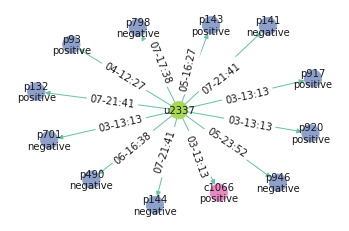

In [428]:
subG = nx.subgraph(G, path + [node_name])
pos = nx.spring_layout(subG)
fig = plt.figure()
ax = fig.subplots()

nx.draw(
    subG, ax=ax,
    with_labels=True,
    node_color=[use_color[color_map[subG.nodes[n]["kind"]]] for n in subG.nodes],
    edge_color=[use_color[color_map[subG.edges[e]["kind"]]] for e in subG.edges],
    labels={n: f"{n}\n{subG.nodes[n]['senti']}" if subG.nodes[n]['kind'] != "user" else n for n in subG.nodes},
    font_size=10,
)

nx.draw_networkx_edge_labels(
    subG, pos=pos, ax=ax,
    edge_labels={e: f"{subG.edges[e]['time']:%d-%H:%M}" for e in subG.edges}
)

# ax.set_title(f"Auxilary graph")
print("")

In [429]:
user_timeline = {
    f"{node_name}_{i+1}": {
        "node": G.nodes[node_name],
        "time": timeline[i],
        "change": get_change(node_name, topic)[i],
    } for i in range(5)
}

print(user_timeline)

{'u2337_1': {'node': {'id': 2337, 'kind': 'user', 'name': 'Luke_8468', 'observer': True, 'sock': False}, 'time': Timestamp('2020-09-04 03:59:59+0000', tz='UTC', freq='D'), 'change': 3.0}, 'u2337_2': {'node': {'id': 2337, 'kind': 'user', 'name': 'Luke_8468', 'observer': True, 'sock': False}, 'time': Timestamp('2020-09-05 03:59:59+0000', tz='UTC', freq='D'), 'change': 0.0}, 'u2337_3': {'node': {'id': 2337, 'kind': 'user', 'name': 'Luke_8468', 'observer': True, 'sock': False}, 'time': Timestamp('2020-09-06 03:59:59+0000', tz='UTC', freq='D'), 'change': 0.0}, 'u2337_4': {'node': {'id': 2337, 'kind': 'user', 'name': 'Luke_8468', 'observer': True, 'sock': False}, 'time': Timestamp('2020-09-07 03:59:59+0000', tz='UTC', freq='D'), 'change': 0.0}, 'u2337_5': {'node': {'id': 2337, 'kind': 'user', 'name': 'Luke_8468', 'observer': True, 'sock': False}, 'time': Timestamp('2020-09-08 03:59:59+0000', tz='UTC', freq='D'), 'change': 0.0}}


In [430]:
tree_full = {**tree, **user_timeline}
path_full = sorted(path + list(user_timeline.keys()), key=lambda x: tree_full[x]["time"])

pathG = nx.DiGraph()

pathG.add_nodes_from(path_full)

for i in range(len(path_full)):
    for j in range(i+1, len(path_full)):
        x = path_full[i]
        y = path_full[j]
        if y[0] == "u" and x[0] != "u":
            pathG.add_edge(y, x, **G.edges[(y[:-2], x)])
            break

nx.set_node_attributes(
    pathG,
    {
        n: {
           "color": use_color[color_map[tree_full[n]["node"]["kind"]]],
        }
        for n in pathG.nodes
    }
)

nx.set_edge_attributes(
    pathG,
    {
        e: {"color": use_color[color_map[pathG.edges[e]["kind"]]]}
        for e in pathG.edges
    }
)

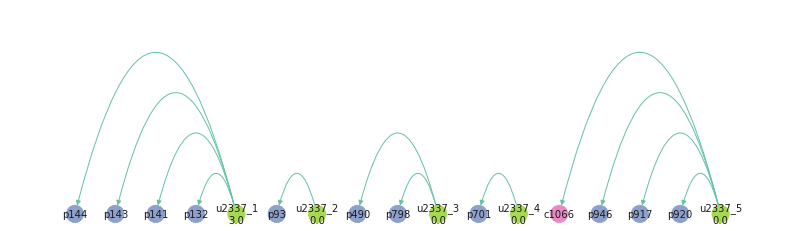

In [431]:
# pos = { for n in pathG.nodes}
pos = {}
for n in pathG.nodes:
    pos[n] = np.array([len(pos), 0])

fig = plt.figure(figsize=(14, 4))
ax = fig.subplots()

nx.draw(
    pathG,
    pos=pos,
    ax=ax,
    with_labels=True,
    font_size=10,
    node_color=[pathG.nodes[n]["color"] for n in pathG.nodes],
    edge_color=[pathG.edges[e]["color"] for e in pathG.edges],
    labels={n: f"{n}" if n[0]!="u" else f"{n}\n{tree_full[n]['change']}" for n in pathG.nodes},
    connectionstyle="arc3,rad=2",
)
